# Day 11: Guiding Decisions with Optimization

---

Let's talk about how we can use the optimization ideas we've seen so far to help guide design decisions:

- Multiple objectives
  - Pareto frontier as "menu"; use supporting information
  - Oar materials revisited:
    - Why not rigid foams?
    - Why not technical ceramics?
  - Transforming to constraints
- Constraints
  - active vs inactive


In [4]:
import pandas as pd 
import grama as gr 
import numpy as np
from plotnine import *
DF = gr.Intention()


# Multiple Objectives

---

## Recall: Oar material selection

---

From our study, we found that we wanted to maximize $I_{\text{oar}} = E^{1/2} / \rho$. If we "split this up" we have

$$\max\, E$$
$$\min\, \rho$$


![ashby plot](./images/ashby-fig6.2.png)


### Why not technical ceramics?

Ceramics are brittle; they fracture easily (compared to wood and CFRP).


### Why not rigid foams?

For one thing, rigid foams have low toughness, but there's another reason we should discount them.

Let's use our optimal radius:

$$r^* = \left( \frac{4}{3\pi} \frac{FL^3}{E} \frac{1}{\delta_{\max}} \right)^{1/4}$$

So the ratio between the optimal radius for different materials---all else but $E$ equal---would be:

$$r_1 / r_2 = (E_2 / E_1)^{1/4}$$

Note that $E_{\text{wood}} / E_{\text{foam}} \approx 10^2$, thus

$$r_{\text{foam}} = 10^{1/2} r_{\text{wood}} \approx 3 r_{\text{wood}}$$

or $A_{\text{foam}} = 10 A_{\text{wood}}$. This would be rather unwieldy, plus real rowers are unlikely to buy these because they'd look comical. There would probably be drag concerns as well.

**Conclusion**: Maybe we were missing a constraint; a maximum radius.


### Niches: Wood or CFRP?

CFRP is a little further out along the $E^{1/2} / \rho$ contour, indicating that it is a higher-performing material as an oar (stiffness-constrained beam). So why aren't all oars made of CFRP?

CFRP is a more modern material than wood and for a long while it has been more expensive to manufacture. So a CFRP oar might be desirable for Olympic athletes (who are willing to spend a ton for an edge), but less desirable to someone just starting out rowing. Wood oars would tend to be less expensive, so they may be a "good enough" product for a novice rower.

We can use the Pareto frontier to help select a *single* candidate. However, we can also use the Pareto frontier to organize our thinking about a *range* of candidates. In a commercial product space there are often [niche markets](https://en.wikipedia.org/wiki/Niche_market); subsets of the market that specific products target. By organizing all existing products on a Pareto frontier, you might find that a particular part of the frontier isn't covered. This could be evidence that no market exists for that hypothetical product... or that there's a niche market that no one is targeting!


## Exchange constants

---

We talked about the *weight method* to identify individual points on the Pareto frontier. By using a variety of weights, you can sketch-out a Pareto frontier by finding individual non-dominated points.

One way we can choose a *single* set of weights is to compute [exchange coefficients](https://www.sciencedirect.com/topics/engineering/exchange-constant); these represent the rate at which we would "exchange" one objective for another.

### Example exchange constants: US Dollars for Mass

One easy-to-understand case of an exchange coefficient is money for mass. Using problem-specific knowledge, it's often possible to *estimate* the cost associated with a unit of mass. For the following transportation categories, a different Basis was used to estimate the cost of having an additional kilogram of mass in the vehicle structure.

| Sector | Basis | Exchange (USD / kg) |
|---|---|---|
| Family car | Fuel savings | 1-2 |
| Truck | Payload | 5-20 |
| Civil aircraft | Payload | 100-500 |
| Military aircraft | Payload/performance | 500-1,000 |
| Spacecraft | Payload | 3,000-10,000 |

Adapted from Table 9.2 in Ashby (1994)


Let's look at an example; suppose we have the following profit vs mass relationship. Clearly we want

$$\max\, \text{Profit}$$
$$\min\, \text{Mass}$$


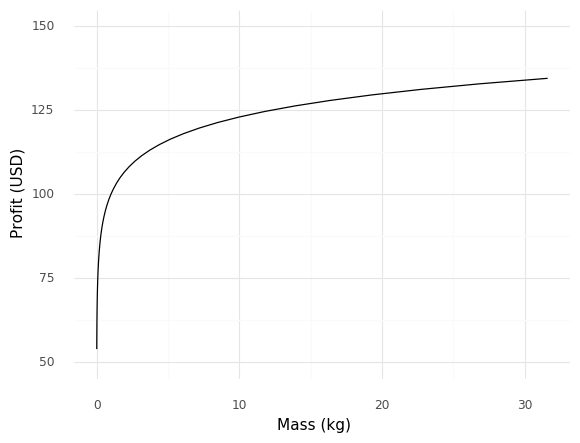

<ggplot: (8769230936113)>

In [79]:
md_cost = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            mass=df.x * 1,
            profit=(np.log(df.x) + 10) * 10,
        ),
        var=["x"],
        out=["mass", "profit"]
    )
    >> gr.cp_bounds(x=(1e-3, 1e2))
)

(
    md_cost
    >> gr.ev_df(df=gr.df_make(x=np.logspace(-2, 1.5)))
    
    >> ggplot(aes("mass", "profit"))
    + geom_line()
    
    + coord_cartesian(ylim=(50, 150))
    + theme_minimal()
    + labs(
        x="Mass (kg)",
        y="Profit (USD)",
    )
)

Set a specific exchange coefficient to pick a particular point on the Pareto frontier.


          x      x_0     out_net      profit      mass  success  \
0  9.999948  50.0005 -113.025851  123.025799  9.999948     True   

                                 message  n_iter  
0  Optimization terminated successfully.      13  


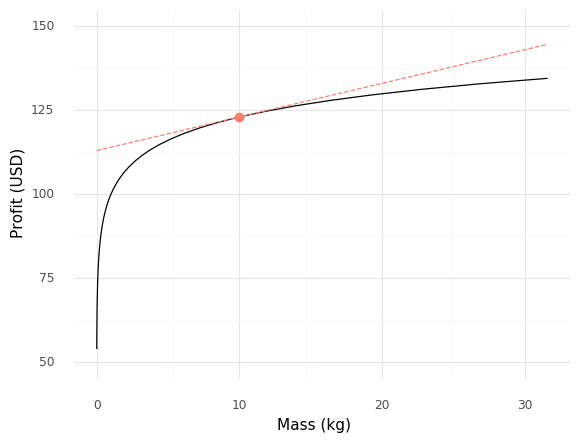

<ggplot: (8769230905965)>

In [78]:
# Set the exchange coefficient
m2c = 1 # Family car
# m2c = 10 # Truck
# m2c = 100 # Civil aircraft
# m2c = 1e3 # Military aircraft
# m2c = 1e4 # Spacecraft

# Solve minimization with selected weight
df_opt = (
    md_cost
    >> gr.cp_function(
        fun=lambda df: gr.df_make(
            # min -profit -> max profit
            # min m2c * mass -> min cost of mass
            out_net = -df.profit + m2c * df.mass
        ),
        var=["profit", "mass"],
        out=["out_net"]
    )
    
    >> gr.ev_min(out_min="out_net")
)
print(df_opt)

# Compute tangent line
profit0 = float(df_opt.profit[0] - m2c * df_opt.mass[0])
df_tangent = (
    gr.df_make(mass=np.logspace(-2, +1.5))
    >> gr.tf_mutate(profit=profit0 + m2c * DF.mass)
)

# Visualize
(
    md_cost
    >> gr.ev_df(df=gr.df_make(x=np.logspace(-2, 1.5)))
    
    >> ggplot(aes("mass", "profit"))
    + geom_line()
    # Annotation layers
    + geom_line(
        data=df_tangent,
        linetype="dashed",
        color="salmon",
    )
    + geom_point(
        data=df_opt,
        color="salmon",
        size=3,
    )
    
    + coord_cartesian(ylim=(50, 150))
    + theme_minimal()
    + labs(
        x="Mass (kg)",
        y="Profit (USD)",
    )
)

## Transform objectives into constraints

---

Do we really need to optimize *everything*?

- Does the user actually *care* about all your objectives?
  - Will they be satisfied with a "good enough" solution along some objectives?
  - Importance of understanding the user!!!
- Are there norms in your discipline?
  - e.g. in aircraft design we usually pose range, capacity, cruising speed, etc. as *minimum-threshold constraints*. The primary objective is minimum weight / cost.
- [satisficing](https://en.wikipedia.org/wiki/Satisficing) -> finding a "good enough" solution; work in behavioral economics suggests that this is how people *actually* make (some) decisions


# Learning from Constraints

---


In [80]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()
md_beam.printpretty()


model: Cantilever Beam

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]
    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}
    copula:
        Independence copula
  functions:
    cross-sectional area: ['w', 't'] -> ['c_area']
    limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
    limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']


In [86]:
md_det = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.eval_conservative(
            md_beam,
            df_det=df,
            quantiles=0.01,
        ),
        var=["w", "t"],
        out=["c_area", "g_stress", "g_disp"],
        name="Nominal evaluation",
    )
    >> gr.cp_bounds(
        w=(2, 4),
        t=(2, 4),
    )
)

md_det.printpretty()


model: None

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]
    var_rand:
    copula:
        None
  functions:
    Nominal evaluation: ['w', 't'] -> ['c_area', 'g_stress', 'g_disp']


In [87]:
(
    md_det
    >> gr.ev_min(
        out_min="c_area",
        out_geq=["g_stress", "g_disp"]
    )
)


,w,t,w_0,t_0,g_stress,g_disp,c_area,success,message,n_iter
0,2.53442,4.0,3.0,3.0,-1.764838e-11,0.380808,10.137679,True,Optimization terminated successfully.,6


If we wanted to minimize the area *further*, which constraint should we edit?

- Changing an inactive constraint won't affect things; we shouldn't bother with the bounds on `w` nor the displacement constraint.
- The stress constraint is *non-negotiable*; a broken beam is not a useful beam!
- We're left with the thickness bounds `t = (2, 4)`. By making this wider, we could potentially improve on the optimum area.


In [90]:
(
    md_det
    >> gr.cp_bounds(t=(2, 8))
    >> gr.ev_min(
        out_min="c_area",
        out_geq=["g_stress", "g_disp"],
    )
)


,w,t,w_0,t_0,g_stress,g_disp,c_area,success,message,n_iter
0,2.454268,4.129225,3.0,5.0,-4.924259e-11,0.327718,10.134227,True,Optimization terminated successfully.,8


Note that this new optimum is just a little thicker than the prior solution; in this case relaxing our thickness bound paid off!


# References

---

- Ashby *Materials Selection in Mechanical Design* (1994), 3rd Edition.